### Amostragem ideal de um sinal analógico e reconstrução utilizando o filtro passa baixa ideal

In [202]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

### ***Construção do sinal***

1) Gerar o sinal 𝑥(𝑡)=cos⁡(2𝜋100𝑡) no intervalo de -5 a 5 segundos.

Frequência de amostragem ($f_s$): 300 Hz
Frequência com maior contribuinte: 100.0 Hz

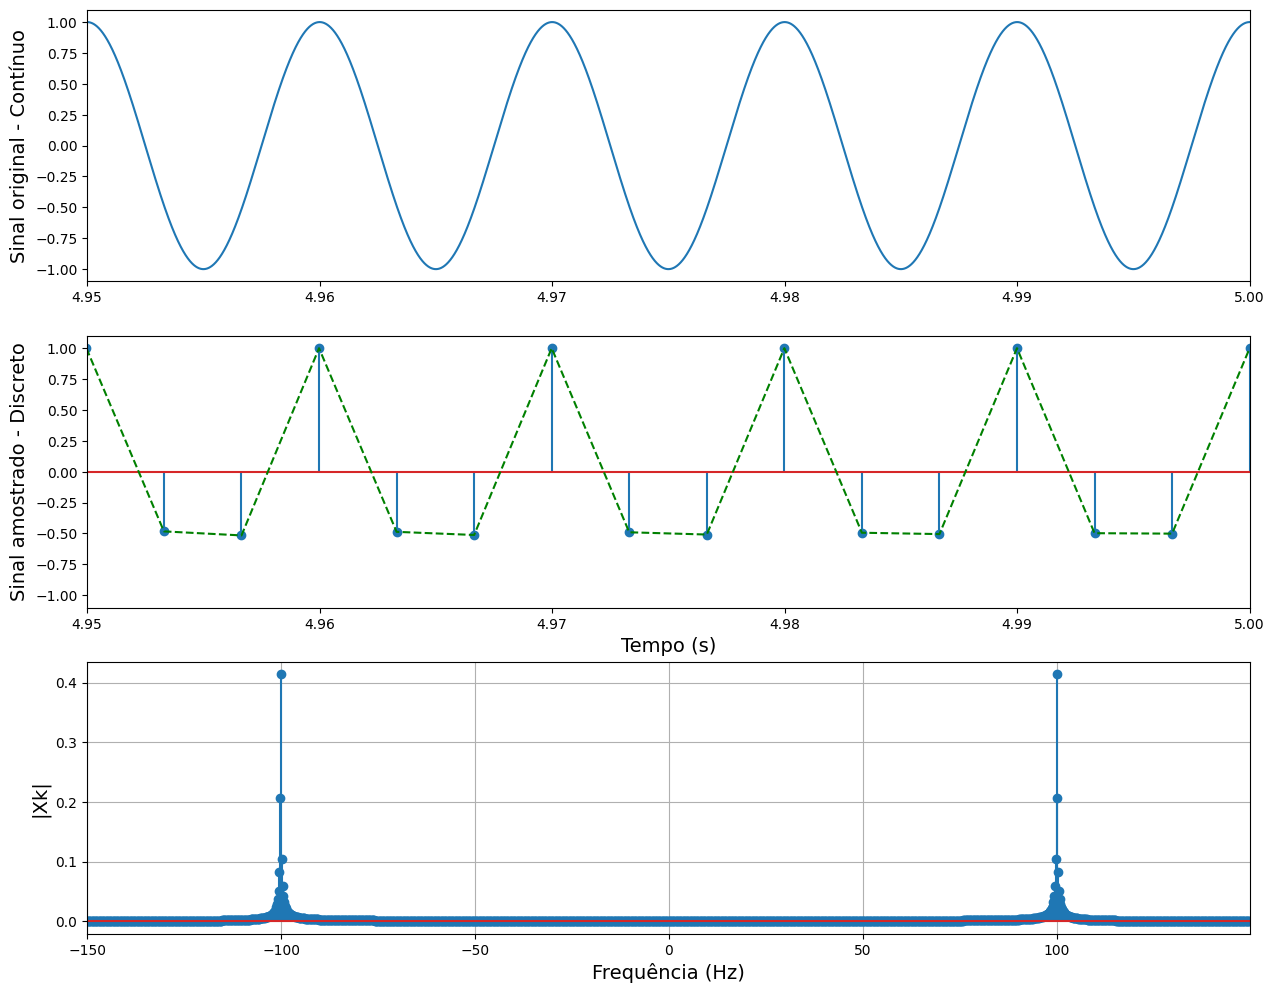

In [203]:
#-------PARAMETROS--INICIAIS--------------------------
# Informacoes do tom e frequencia de amostragem
ti = 0
tf = 5
fa = 100
fs = 300
amostras = True 
interpolado = True
ciclosMostrar = 5
EMQamostras = 10000
fs_analogico = 1e6
A = False
C = True
OTIMIZAR_TEMPO = True

#------------------------------------------------------

def spectrum(xa, T0):
  fs = int(len(xa)/T0)
  Xk = np.fft.fft(xa)
  hs = np.abs(Xk)
  hs *= 1/len(xa)
  freqs = np.fft.fftfreq(len(xa), 1./fs)
  return freqs, hs

def plot_spectrum(xr,ttot, limFreq = False):
    freqs, hs = spectrum(xr, ttot)
    print(f"""Frequência com maior contribuinte: {abs(round(freqs[np.argmax(hs)],2))} Hz""", end='')

    if limFreq:
      freqs_fs = len(freqs)/(max(freqs)-min(freqs))
      freqs = np.fft.fftshift(freqs)
      hs = np.fft.fftshift(hs)
      Nmin = int(np.floor((-limFreq - min(freqs))*freqs_fs))
      Nmax = int(np.ceil((limFreq - min(freqs))*freqs_fs))
      plt.stem(freqs[Nmin:Nmax], hs[Nmin:Nmax], '-o')
      plt.xlim([-limFreq, limFreq])
    else:
      plt.stem(freqs, hs, '-o')
      plt.xlim([min(freqs), max(freqs)])
    plt.xlabel("Frequência (Hz)", fontsize=14)
    plt.ylabel("|Xk|", fontsize=14)
    plt.grid('on')

#------------------------------------------------------

ttot = tf -ti
t = np.linspace(ti,tf,int(ttot*fs_analogico)) # fs=1e6 para simular o analogico
xt = np.cos(2*np.pi*fa*t)

tsampling = np.linspace(ti,tf,int(ttot*fs))
xtsampling = np.cos(2*np.pi*fa*tsampling)

print(f"""Frequência de amostragem ($f_s$): {fs} Hz""")

fig = plt.figure(figsize=(15,12)) # comprimento (x) e altura (y)
plt.subplot(311)
plt.plot(t, xt)
plt.ylabel("Sinal original - Contínuo", fontsize=14)
plt.xlim([tf-ciclosMostrar/fa, tf])

plt.subplot(312)
if amostras:
  plt.stem(tsampling, xtsampling)
if interpolado:
  plt.plot(tsampling, xtsampling, color='green', linestyle='dashed')
plt.ylabel("Sinal amostrado - Discreto", fontsize=14)
plt.xlabel("Tempo (s)", fontsize=14)
plt.xlim([tf-ciclosMostrar/fa, tf])

plt.subplot(313)
plot_spectrum(xtsampling, ttot)

plt.show()

### ***Reconstrução do sinal***

2) Após fazer a amostragem do sinal seguindo a observação (\*), reconstruir o sinal em um intervalo de tempo To, compreendido entre 0 e 1, com base no teorema da dimensionalidade e a resposta impulsiva do filtro passa baixa ideal (versão truncada). Qual será a frequência do sinal recuperado?
(*)O Teorema da Dimensionalidade fornece o número mínimo de amostras para reconstrução do sinal, ou seja, N amostras em um intervalo de tempo To (Couch). Determine a frequência de amostragem, considerando que você a utilizará para reconstrução do sinal no intervalo To, o seguinte número de amostras V:

a) V = (N + 1) amostras (pois estamos reconstruindo um tom);


b) V igual a 3N;

Pelo teorema da dimensionalidade, serão necessárias $N$ amostras, sendo

$$N = 2\ B\ T_0$$
$$N = 2*100*1 = 200$$

Sabendo que serão utilizadas V amostras, em que V depende de N, então tem-se a frequência de amostragem:

$$V = fs\ T_0$$
$$fs = V/T_0 \text{, em amostras/segundo}$$ 

V = 750 amostras
No sinal "analógico": 5000000 amostras
No intervalo calculado: 50000 amostras


  0%|          | 0/750 [00:00<?, ?it/s]

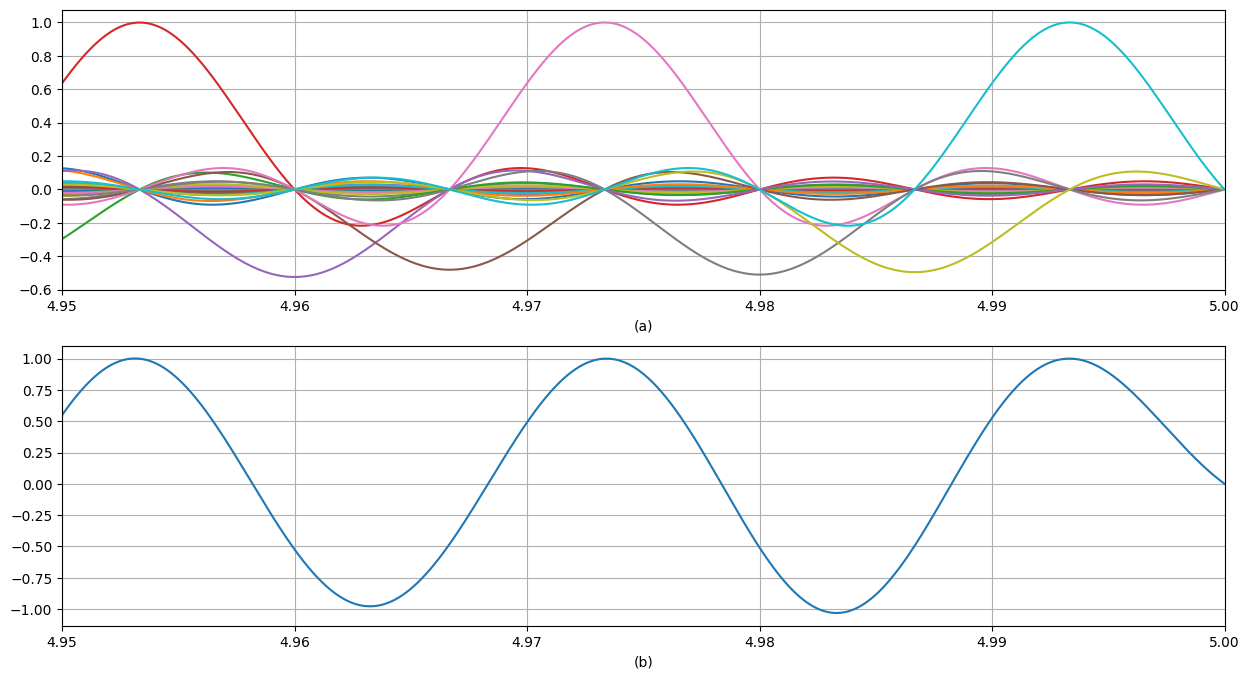

In [204]:
N = int(np.ceil(2*fa*ttot))

def h(t, fs): # filtro
    return np.sinc(fs*t) 

#--A----------------
if A:
    V = N + 1
#--B----------------
else:
    V = 3*N
#-------------------

fs = V/ttot

if C:
    fs = 150
    V = fs*ttot

Ts = 1/fs
tsampling = np.linspace(ti,tf,int(ttot*fs))
xtsampling = np.cos(2*np.pi*fa*tsampling)

# Otimizando o tempo de processamento, processamendo somente o necessário
if OTIMIZAR_TEMPO:
    xr_amostras = int(np.ceil((ciclosMostrar/fa-t[0])*fs_analogico)) 
    xr = np.zeros(xr_amostras)
    txr = t[-xr_amostras::]
    print(f"""V = {V} amostras
No sinal "analógico": {len(t)} amostras
No intervalo calculado: {len(xr)} amostras""")

    plt.figure(figsize=[15,8])
    plt.subplot(211)
    for i in tqdm(range(0,V)):
        xr = xr + xtsampling[i]*h(txr-i*Ts, fs)
        plt.plot(txr,xtsampling[i]*h(txr-i*Ts, fs))
    plt.xlabel("(a)")
    plt.xlim([tf-xr_amostras/fs_analogico , tf])
    plt.grid()

    plt.subplot(212)
    plt.plot(txr,xr)
    plt.xlabel("(b)")
    plt.xlim([tf-xr_amostras/fs_analogico , tf])
    plt.grid()
    plt.show()
else:
    xr_amostras = len(t)
    xr = np.zeros(xr_amostras)
    txr = t[-xr_amostras::]
    print(f"""V = {V} amostras
No sinal "analógico": {len(t)} amostras
No intervalo calculado: {len(xr)} amostras""")
    for i in tqdm(range(0,V)):
        xr = xr + xtsampling[i]*h(txr-i*Ts, fs)
        

    

\vspace{12pt}
\noindent Resultado obtido:

Frequência com maior contribuinte: 40.0 Hz\\
\indent Frequência de amostragem ($f_s$): 150 Hz\\
\indent Erro médio quadrático (EMQ): 2.59e-03\\
\vspace{12pt}

T_0 = [0,5] segundos
A = False
C = True



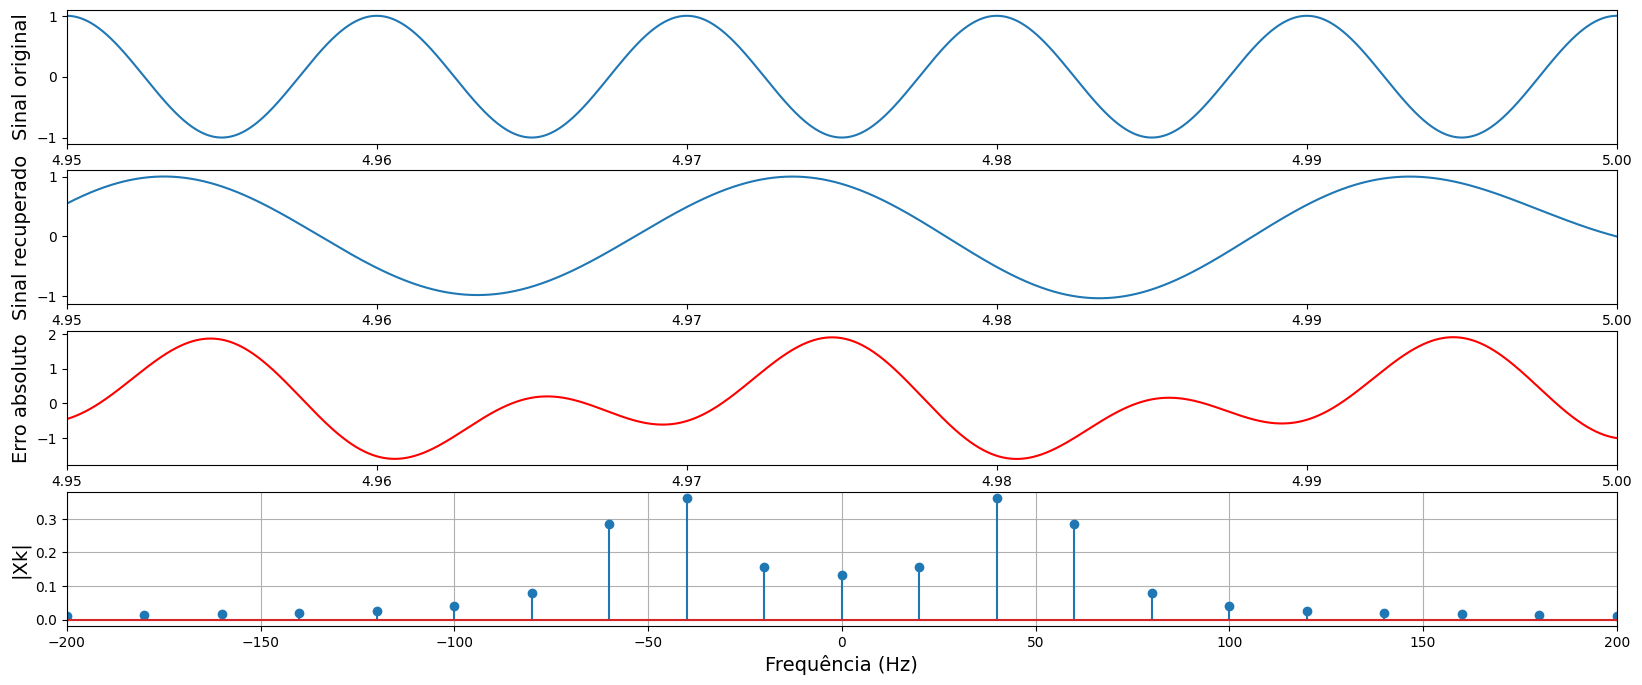

In [205]:
plt.figure(figsize=(20,8))

plt.subplot(411)
plt.plot(t, xt)
plt.ylabel("Sinal original", fontsize=14)
plt.xlim([tf-ciclosMostrar/fa,tf])

plt.subplot(412)
plt.plot(txr,xr)
plt.ylabel("Sinal recuperado", fontsize=14)
plt.xlim([tf-ciclosMostrar/fa,tf])

plt.subplot(413)
plt.plot(txr,xr-xt[-xr_amostras::], "red")
plt.ylabel("Erro absoluto", fontsize=14)
plt.xlim([tf-ciclosMostrar/fa,tf])

print(f"""\\vspace{{12pt}}
\\noindent Resultado obtido:
""")
      
plt.subplot(414)
plot_spectrum(xr,tf-txr[0], 2*fa)

print(f"""\\\\
\indent Frequência de amostragem ($f_s$): {fs} Hz\\\\
\indent Erro médio quadrático (EMQ): {'{:.2e}'.format(sum((xr[-EMQamostras::]-xt[-EMQamostras::])**2)/len(t))}\\\\

V = {V} amostras\\\\
\indent No sinal "analógico": {len(t)} amostras\\\\
\indent No intervalo calculado: {len(xr)} amostras\\\\
\\vspace{{12pt}}

T_0 = [{ti},{tf}] segundos
A = {A}
C = {C}
""")